In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np

# Tratamento de Dados

In [90]:
# Arquivo Excel
file_path = r'C:\Users\Salvador\Desktop\Afonso\Tese\Dados\ISEG_Bloomberg\Dados.xlsx'

In [91]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

Relativamente aos dados presentes em cada folha de Excel deslocou-se uma linha para baixo (close price), porque quando os dados foram extraídos da Bloomberg no dia 17/07/2024 e o dia ainda não tinha terminado, ou seja, o close price do dia 17/07 era o close price do dia anterior e assim sucessivamente, até ao close price mais antigo.

In [92]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
brent_data = read_sheet('Brent', 'Brent')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

Depois de ter usado todas as variáveis extraídas da Bloomberg e de as ter correlacionado decidi optar apenas por estas, tendo como variável dependente o WTI Crude Oil. O Jet Fuel NWE CIF Cargoes tem, tal como o Brent e como era de esperar, uma correlação de 0.99 com o WTI, no entanto, tem dados apenas desde 2008. A Bitcoin tem dados desde 2010 e tinha uma correlação de 0.10. A taxa de câmbio USD/RUB não tinha dados a partir de 2022 e ambas as moedas estão expostas ao EUR que mostra uma correlação considerável, daí ter optado por retirar do modelo. Por fim, as variáveis total crude oil supply & demand foram retiradas porque, apesar de terem uma correlação aparentemente considerável, têm apenas dados mensais e trimestrais.

In [93]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, brent_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Closing Prices das 5 variáveis

In [94]:
# Exibir os primeiros 5 registros
print(combined_data.head())

            WTI Crude Oil Prices  S&P500    Gold  Silver  Brent  EUR/USD  \
Date                                                                       
1994-01-04                 14.67  466.89  393.85    5.24  13.61   1.1246   
1994-01-05                 15.34  467.55  391.20    5.09  14.26   1.1252   
1994-01-06                 15.42  467.12  388.90    5.12  14.36   1.1252   
1994-01-07                 15.32  469.90  387.10    5.01  14.23   1.1293   
1994-01-10                 14.67  475.27  384.60    5.04  13.74   1.1269   

            EUR/RUB  
Date                 
1994-01-04   1.1088  
1994-01-05   1.1154  
1994-01-06   1.1189  
1994-01-07   1.1148  
1994-01-10   1.1305  


## Dados (1994-2024)

In [95]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [96]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## Gráficos das variáveis

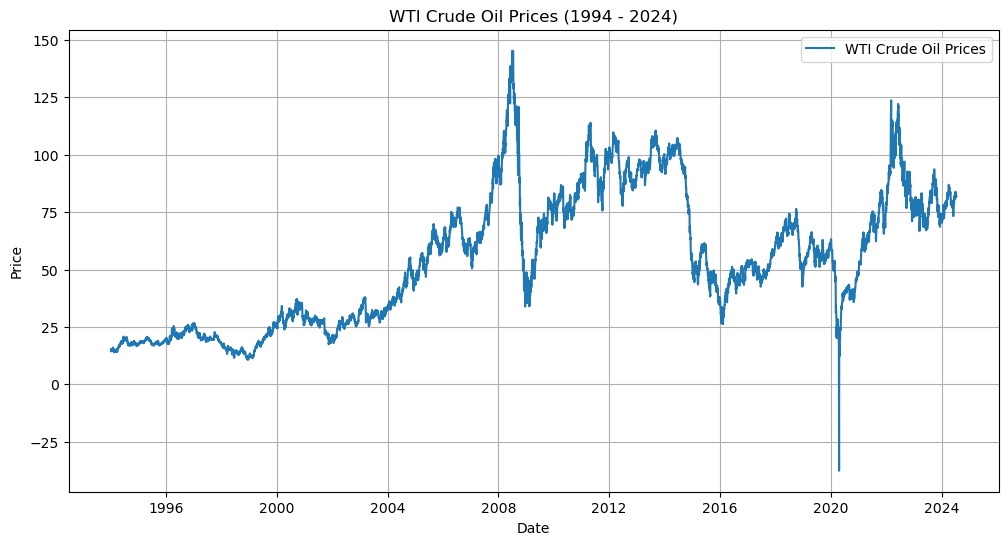

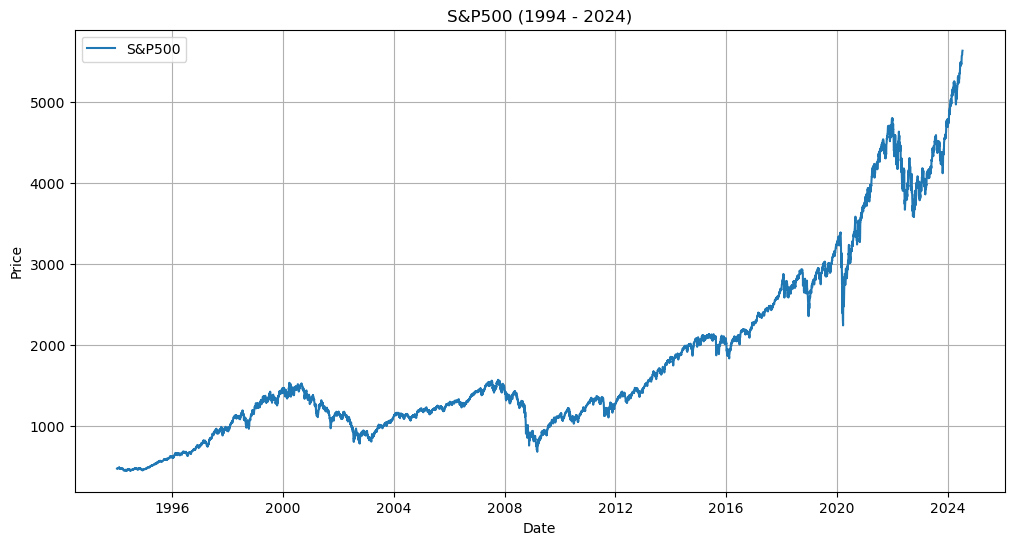

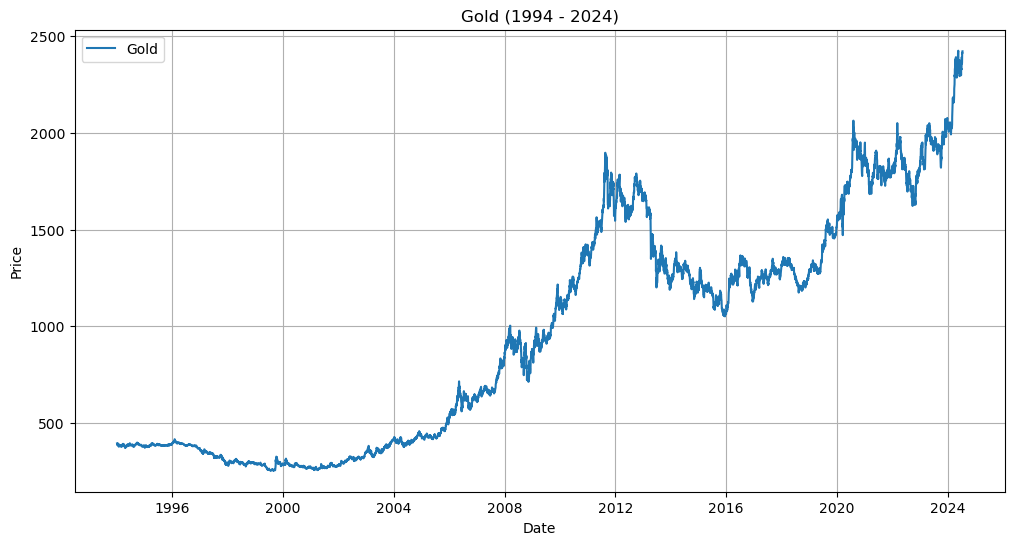

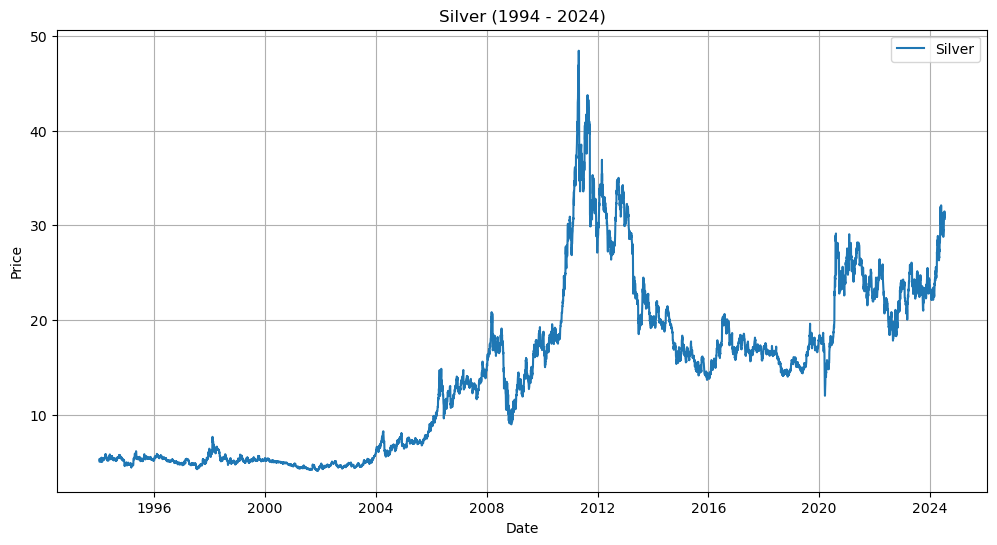

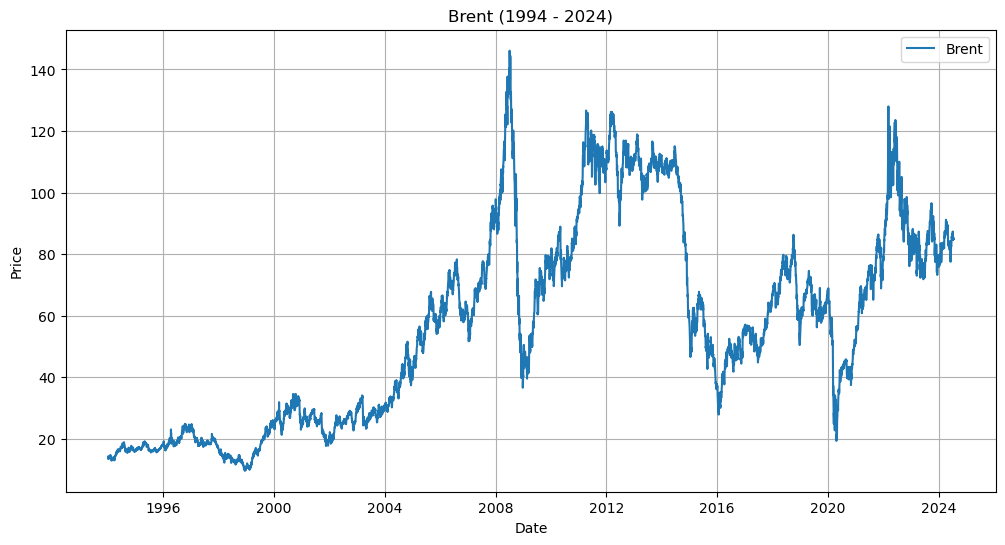

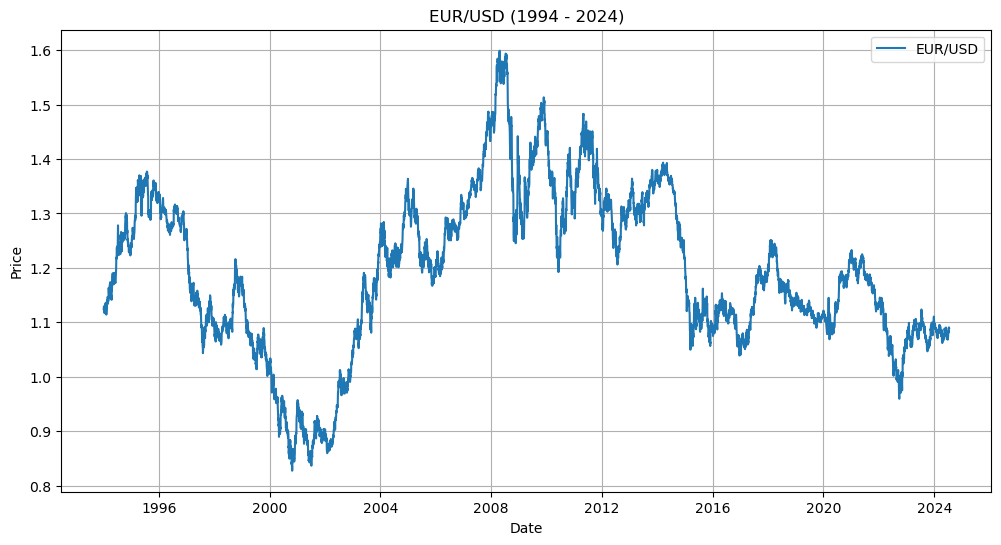

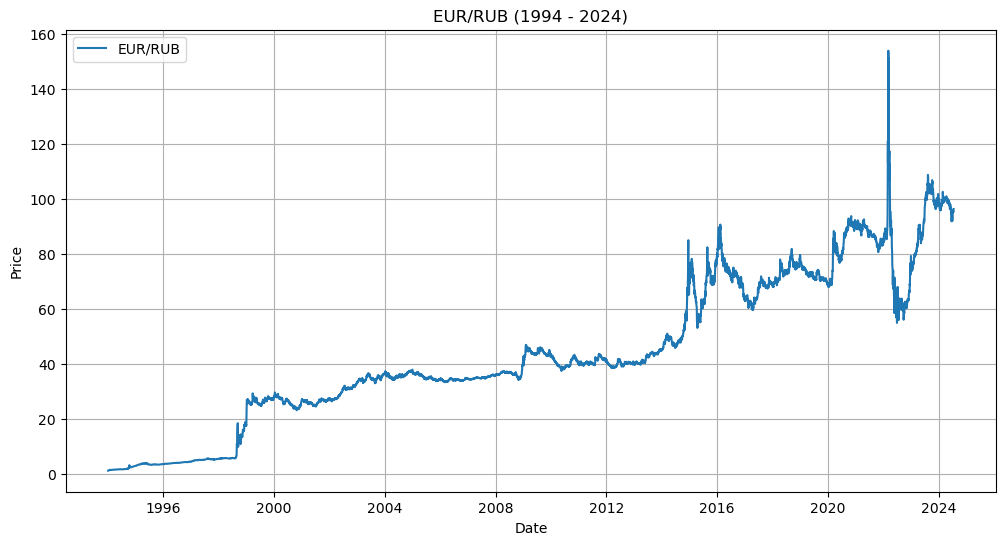

In [97]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'Brent', 'EUR/USD', 'EUR/RUB']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das variáveis

In [98]:
# Descrever as variáveis
description = combined_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-----------+-------------+-----------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     Brent |     EUR/USD |   EUR/RUB |
|-------+------------------------+----------+----------+------------+-----------+-------------+-----------|
| count |              7601      |  7601    | 7601     | 7601       | 7601      | 7601        | 7601      |
| mean  |                54.9368 |  1809.75 |  963.887 |   14.3337  |   57.3906 |    1.19174  |   44.2331 |
| std   |                29.1107 |  1146.46 |  587.178 |    8.81567 |   32.5277 |    0.147932 |   26.8983 |
| min   |               -37.63   |   441.49 |  252.55  |    4.06    |    9.64   |    0.8272   |    1.1088 |
| 25%   |                27.63   |  1092.17 |  382.75  |    5.33    |   26.09   |    1.0922   |   27.3335 |
| 50%   |                53.13   |  1347.35 |  948.53  |   14.5505  |   56.35   |    1.1816   |   39.0733 |
| 75%   |                77.

## Matriz de Correlação (Heatmap)

In [99]:
# Calcular a matriz de correlação
correlation_matrix = combined_data.corr()

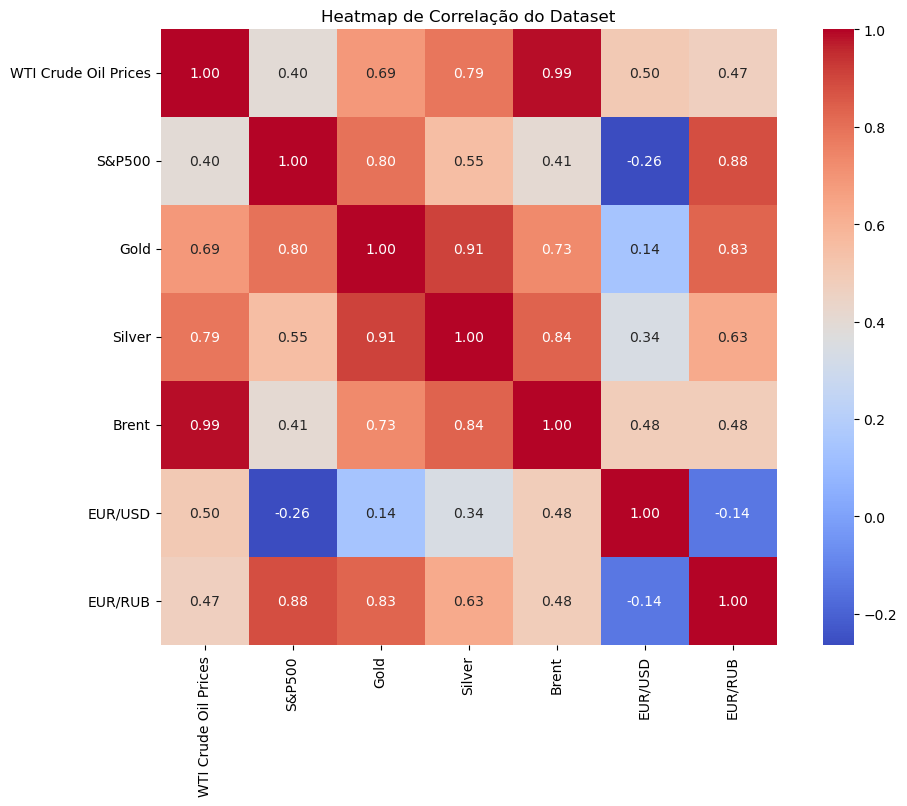

In [100]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Creating Features and Target Variables

A variável a estudar é o WTI Crude Oil, com preços 1994 a 2024, e vamos definir vários horizontes
temporais, nomeadamente, 1, 7, 14, 21 e 30, ou seja, prever o preço do WTI para o próximo dia, para a 
próxima semana, para as próximas duas semanas, 3 semanas e para o próximo mês, usando um daily dataframe e uma window_size de 30 dias.

In [101]:
# Escalar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(filtered_data)

In [102]:
# Função para criar features e targets
def create_features_and_target(data, horizon_days, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon_days + 1):
        X.append(data[i:i+window_size].flatten())
        y.append(data[i+window_size+horizon_days-1][0])  # O target é o preço do WTI Crude Oil
    return np.array(X), np.array(y)

In [103]:
scaled_data.shape

(7601, 7)

In [104]:
# Criar features e targets para cada horizonte
horizons = [1, 7, 14, 21, 30]
features_targets = {}
for horizon in horizons:
    X, y = create_features_and_target(scaled_data, horizon)
    features_targets[horizon] = (X, y)

In [105]:
# Imprimir as formas das features e targets para verificação
for horizon, (X, y) in features_targets.items():
    print(f"Horizon: {horizon} days")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}\n")

Horizon: 1 days
X shape: (7571, 210)
y shape: (7571,)

Horizon: 7 days
X shape: (7565, 210)
y shape: (7565,)

Horizon: 14 days
X shape: (7558, 210)
y shape: (7558,)

Horizon: 21 days
X shape: (7551, 210)
y shape: (7551,)

Horizon: 30 days
X shape: (7542, 210)
y shape: (7542,)



## Train-Test Split

No train-test split usou-se um rácio de 80/20

In [106]:
# Função para dividir os dados em conjuntos de treino e teste
def split_data(X, y, test_size=0.3):
    return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

In [107]:
# Dividir os dados para cada horizonte
split_data_dict = {}
for horizon in horizons:
    X, y = features_targets[horizon]
    split_data_dict[horizon] = split_data(X, y)

In [108]:
# Imprimir as formas dos conjuntos de treino e teste para verificação
for horizon, (X_train, X_test, y_train, y_test) in split_data_dict.items():
    print(f"Horizon: {horizon} days")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}\n")

Horizon: 1 days
X_train shape: (5299, 210)
X_test shape: (2272, 210)
y_train shape: (5299,)
y_test shape: (2272,)

Horizon: 7 days
X_train shape: (5295, 210)
X_test shape: (2270, 210)
y_train shape: (5295,)
y_test shape: (2270,)

Horizon: 14 days
X_train shape: (5290, 210)
X_test shape: (2268, 210)
y_train shape: (5290,)
y_test shape: (2268,)

Horizon: 21 days
X_train shape: (5285, 210)
X_test shape: (2266, 210)
y_train shape: (5285,)
y_test shape: (2266,)

Horizon: 30 days
X_train shape: (5279, 210)
X_test shape: (2263, 210)
y_train shape: (5279,)
y_test shape: (2263,)



## Métricas usadas (RMSE, MAPE, R^2 e MAE)

In [109]:
# Função para treinar e avaliar um modelo de regressão
def train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Horizon: {horizon} days")
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    print(f"{model.__class__.__name__} MAPE: {mape:.4f}")
    print(f"{model.__class__.__name__} MSE: {mse:.4f}")
    print(f"{model.__class__.__name__} R²: {r2:.4f}\n")
    return model, y_pred

# Resultados

## Modelos de Machine Learning

Inicialmente foram usados 4 modelos (Linear, Ridge, Lasso e Elastic Net Regressions) para testar o daily dataframe com os diferentes horizontes temporais (h=1, h=7, h=14, h=21 e h=30). Seguidamente, foram adicionados o Random Forest, XGBoost e o SVR com a RBF de Kernel.

In [110]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [111]:
# Treinar e avaliar os modelos para cada horizonte
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=0.01),  # Lower alpha for Lasso
    ElasticNet(alpha=0.01, l1_ratio=0.5),  # Lower alpha for ElasticNet
    RandomForestRegressor(),
    XGBRegressor(),
    SVR(kernel='rbf')
]

In [112]:
model_names = [
    "Linear Regression",
    "Ridge Regression",
    "Lasso Regression",
    "Elastic Net Regression",
    "Random Forest Regression",
    "XGBoost Regression",
    "SVR"
]

In [113]:
results = {name: {} for name in model_names}
for horizon in horizons:
    X_train, X_test, y_train, y_test = split_data_dict[horizon]
    for model, name in zip(models, model_names):
        trained_model, y_pred = train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon)
        results[name][horizon] = {
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R²": r2_score(y_test, y_pred),
            "y_pred": y_pred
        }

Horizon: 1 days
LinearRegression RMSE: 0.0129
LinearRegression MAPE: 625730388481.7856
LinearRegression MSE: 0.0002
LinearRegression R²: 0.9841

Horizon: 1 days
Ridge RMSE: 0.0126
Ridge MAPE: 630324126273.5920
Ridge MSE: 0.0002
Ridge R²: 0.9850

Horizon: 1 days
Lasso RMSE: 0.0343
Lasso MAPE: 781034706396.3541
Lasso MSE: 0.0012
Lasso R²: 0.8878

Horizon: 1 days
ElasticNet RMSE: 0.0294
ElasticNet MAPE: 766528078479.9017
ElasticNet MSE: 0.0009
ElasticNet R²: 0.9178

Horizon: 1 days
RandomForestRegressor RMSE: 0.0120
RandomForestRegressor MAPE: 607399450660.6057
RandomForestRegressor MSE: 0.0001
RandomForestRegressor R²: 0.9863

Horizon: 1 days
XGBRegressor RMSE: 0.0150
XGBRegressor MAPE: 616496228957.7654
XGBRegressor MSE: 0.0002
XGBRegressor R²: 0.9785

Horizon: 1 days
SVR RMSE: 0.0878
SVR MAPE: 1097703424593.6968
SVR MSE: 0.0077
SVR R²: 0.2653

Horizon: 7 days
LinearRegression RMSE: 0.0254
LinearRegression MAPE: 664904956163.9580
LinearRegression MSE: 0.0006
LinearRegression R²: 0.9384


## Tabelas c/ modelos, horizontes e métricas

Depois de obtidos os resultados foi adicionada esta parte do código para organizar os mesmos dados em tabelas, dividindo-as por horizontes (h=1, h=7, h=14, h=21 e h=30), onde podemos analisar os respetivos modelos e ver que valores do RMSE, MAPE, R^2 e MAE obtiveram.

In [114]:
# Criar tabelas para cada horizonte
from tabulate import tabulate
for horizon in horizons:
    table = [["Model", "RMSE", "MAPE", "MSE", "R²"]]
    for name in model_names:
        result = results[name][horizon]
        table.append([
            name,
            f"{result['RMSE']:.4f}",
            f"{result['MAPE']:.4f}",
            f"{result['MSE']:.4f}",
            f"{result['R²']:.4f}"
        ])
    print(f"\nResults for horizon: {horizon} days")
    print(tabulate(table, headers="firstrow", tablefmt="github"))


Results for horizon: 1 days
| Model                    |   RMSE |        MAPE |    MSE |     R² |
|--------------------------|--------|-------------|--------|--------|
| Linear Regression        | 0.0129 | 6.2573e+11  | 0.0002 | 0.9841 |
| Ridge Regression         | 0.0126 | 6.30324e+11 | 0.0002 | 0.985  |
| Lasso Regression         | 0.0343 | 7.81035e+11 | 0.0012 | 0.8878 |
| Elastic Net Regression   | 0.0294 | 7.66528e+11 | 0.0009 | 0.9178 |
| Random Forest Regression | 0.012  | 6.07399e+11 | 0.0001 | 0.9863 |
| XGBoost Regression       | 0.015  | 6.16496e+11 | 0.0002 | 0.9785 |
| SVR                      | 0.0878 | 1.0977e+12  | 0.0077 | 0.2653 |

Results for horizon: 7 days
| Model                    |   RMSE |        MAPE |    MSE |     R² |
|--------------------------|--------|-------------|--------|--------|
| Linear Regression        | 0.0254 | 6.64905e+11 | 0.0006 | 0.9384 |
| Ridge Regression         | 0.0242 | 6.87918e+11 | 0.0006 | 0.9442 |
| Lasso Regression         | 0.0

In [115]:
# Função para plotar previsões vs valores reais
def plot_predictions(y_test, y_pred, model_name, horizon):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label='True', color='blue')
    plt.plot(range(len(y_test)), y_pred, label=model_name, color='orange')
    plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
    plt.xlabel('Observations')
    plt.ylabel('WTI Crude Oil Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

De seguida, já analisados os dados, plotaram-se os gráficos de cada modelo para se ter uma melhor perceção das previsões que foram feitas, tendo em conta o ratio 80/20 do nosso train-test split. Ou seja, como os dados estão compreendidos entre 1994 a 2024, as nossas previsões contemplam mais de 1400 observações que dizem respeito a 6 anos.

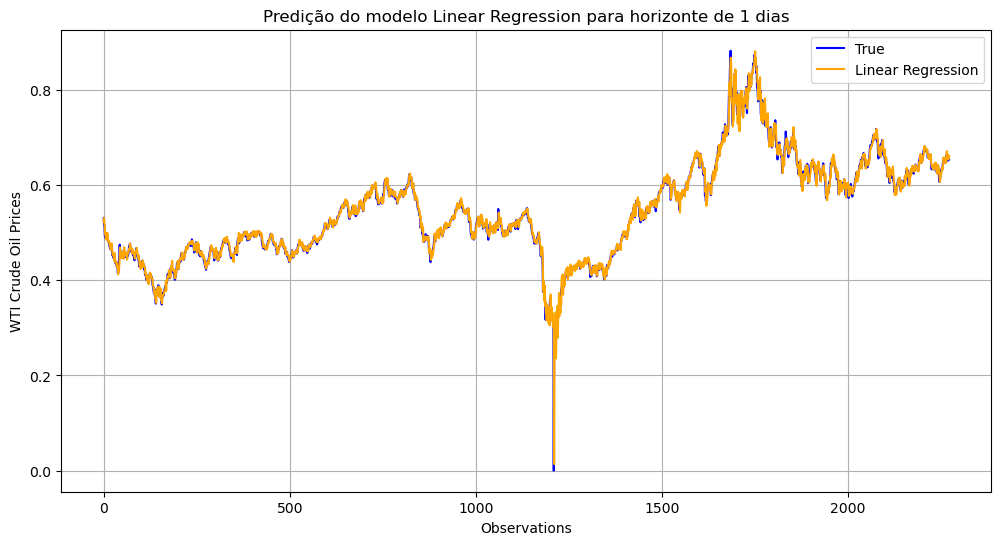

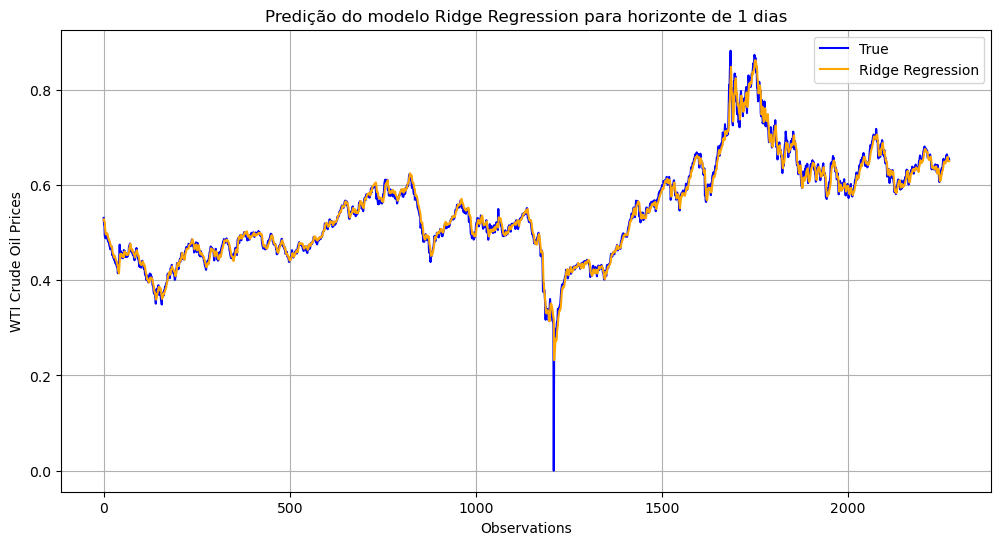

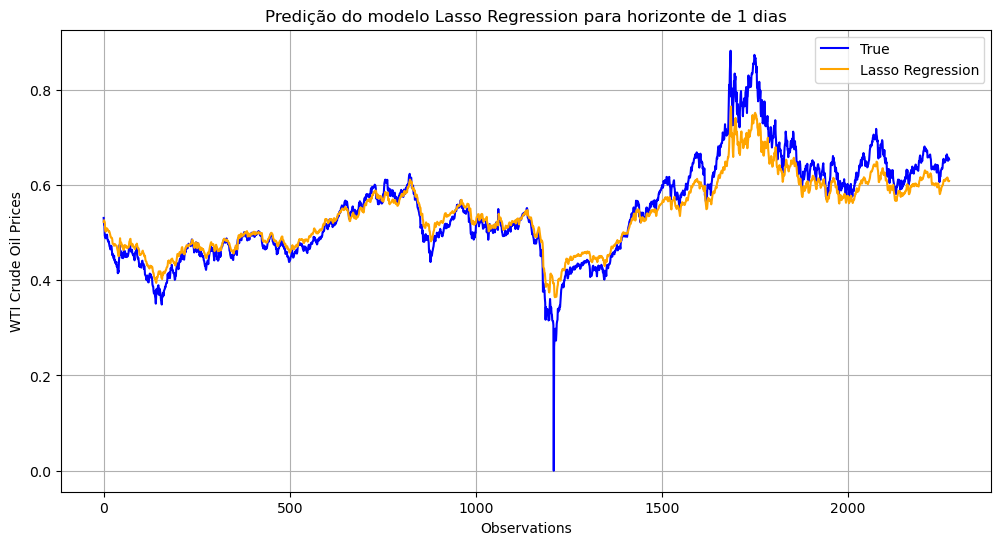

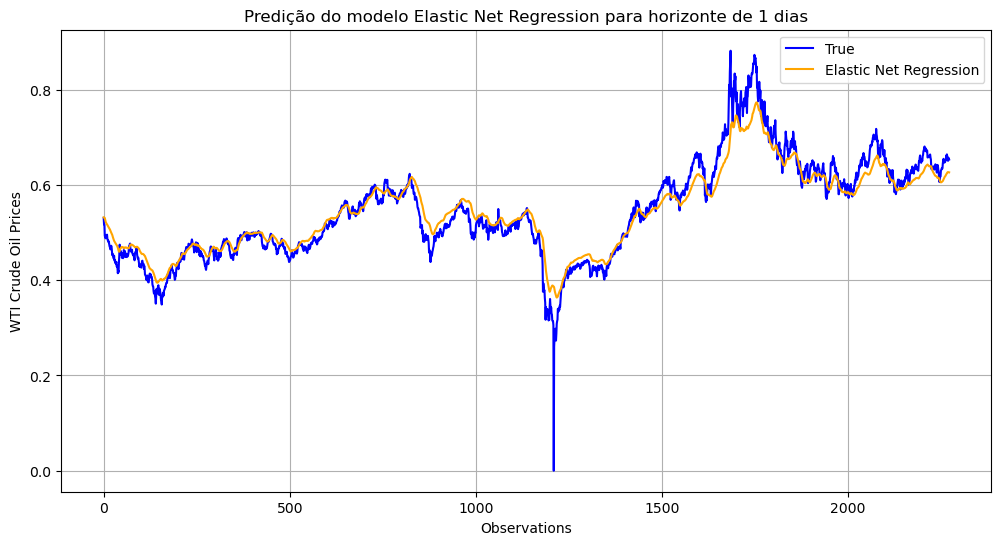

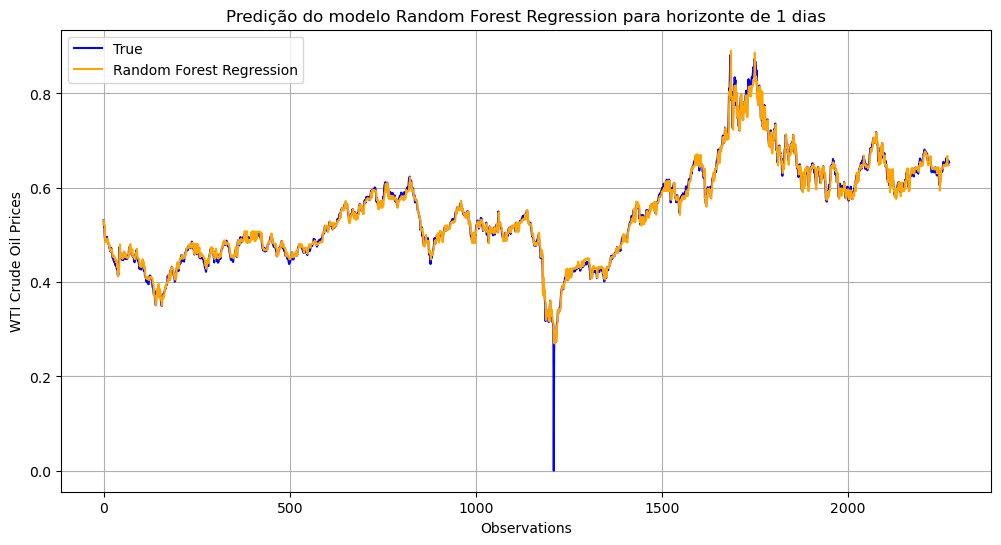

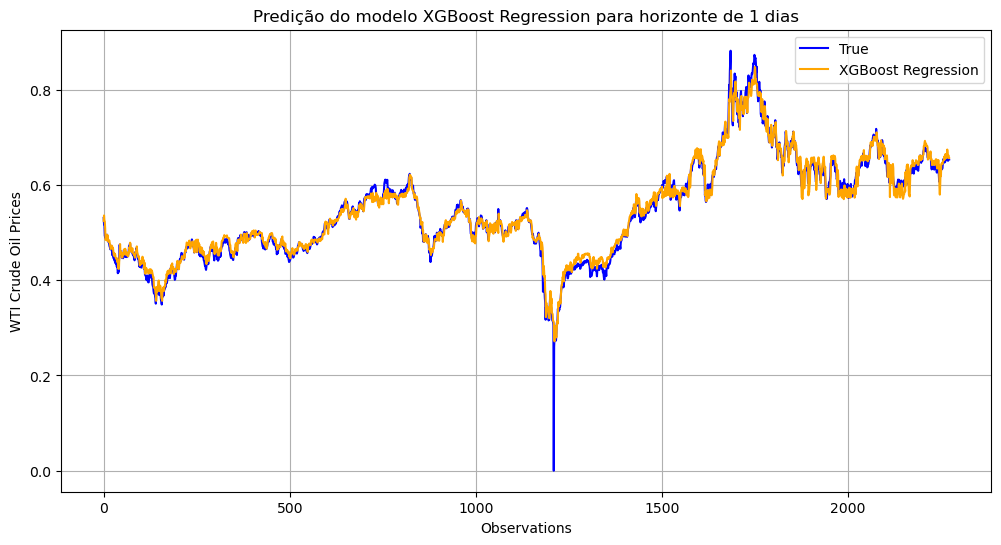

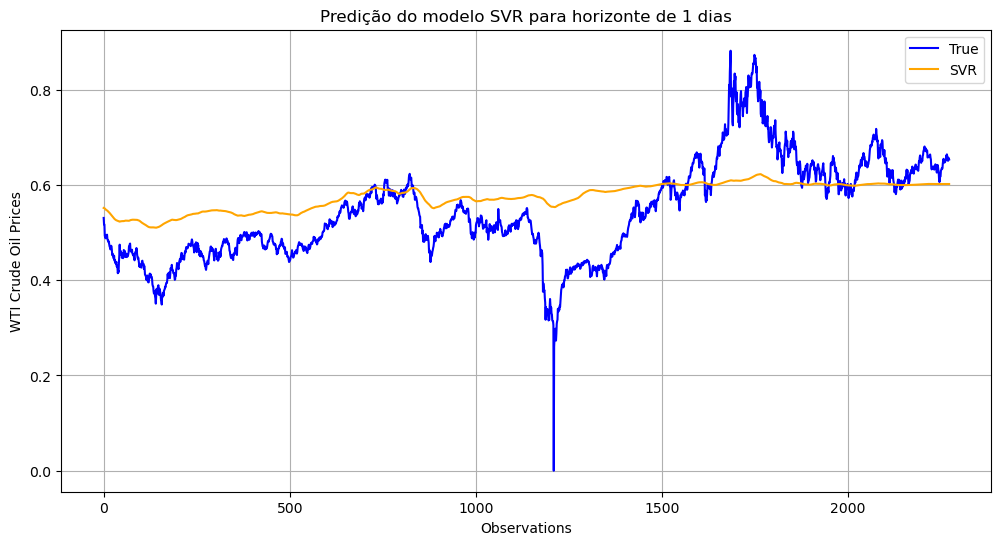

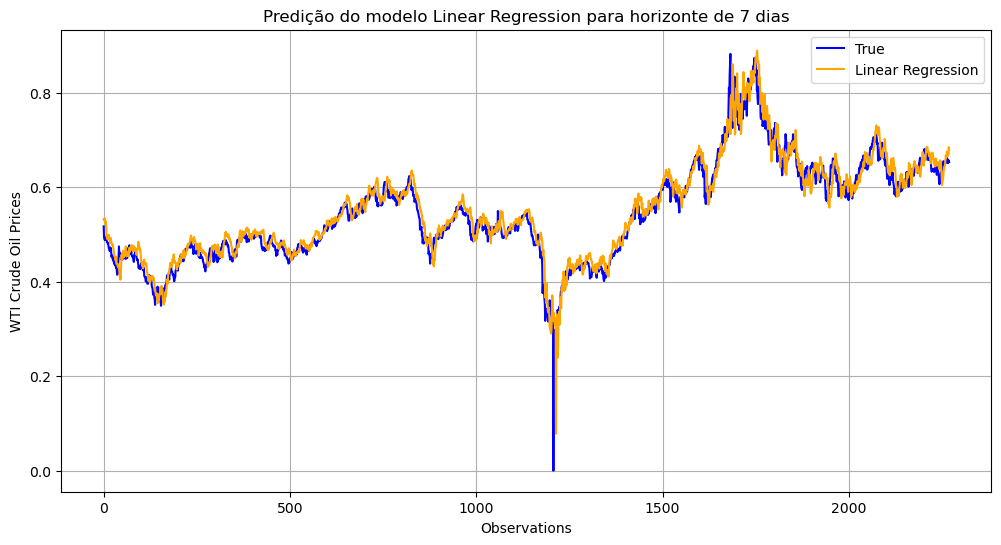

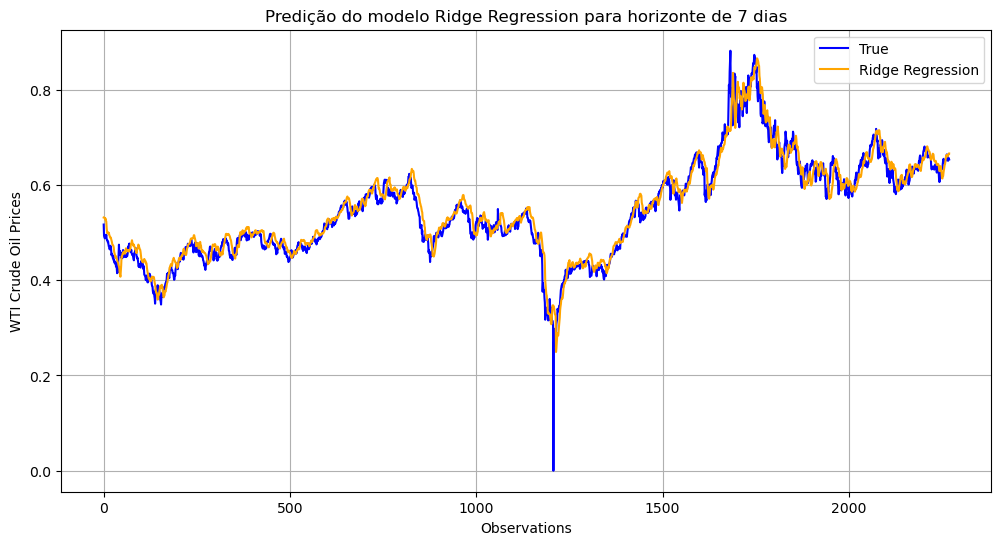

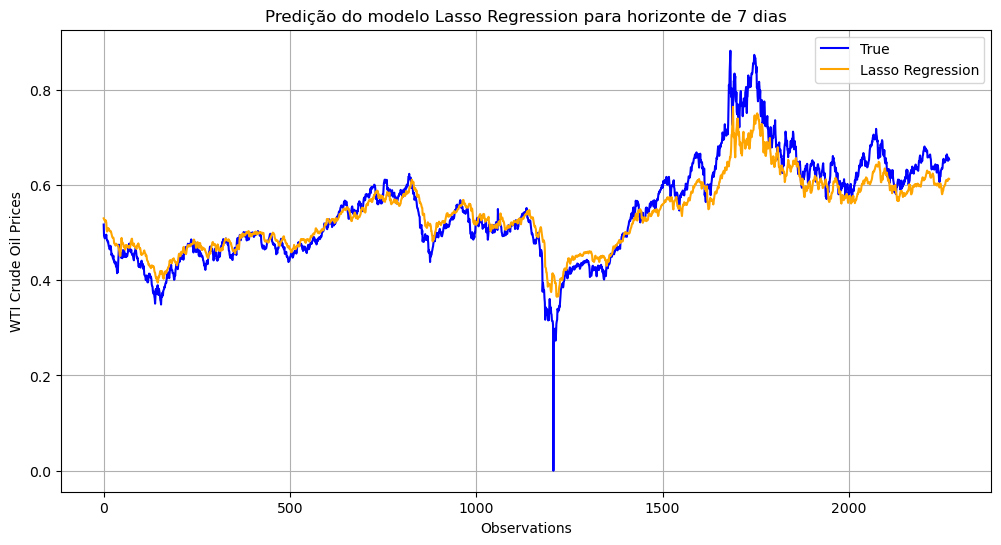

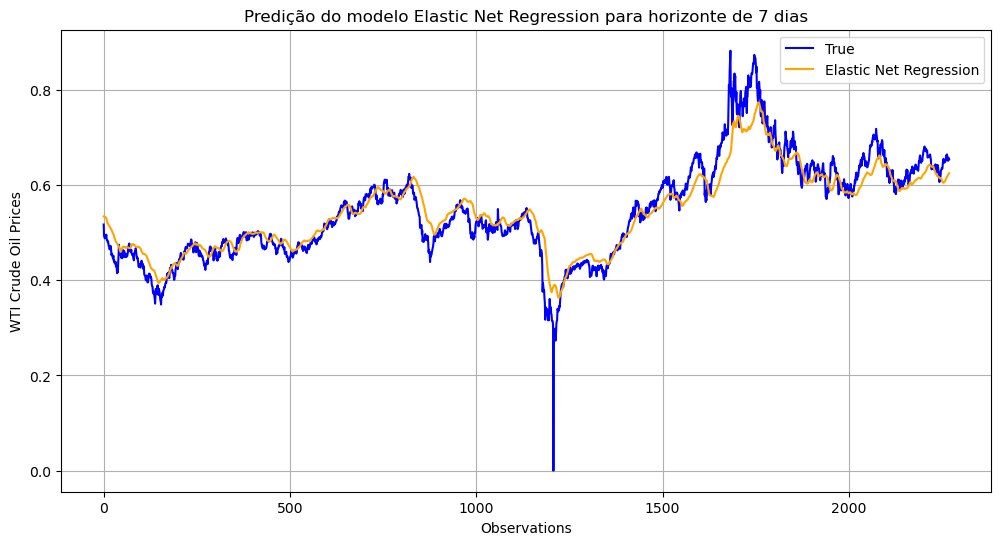

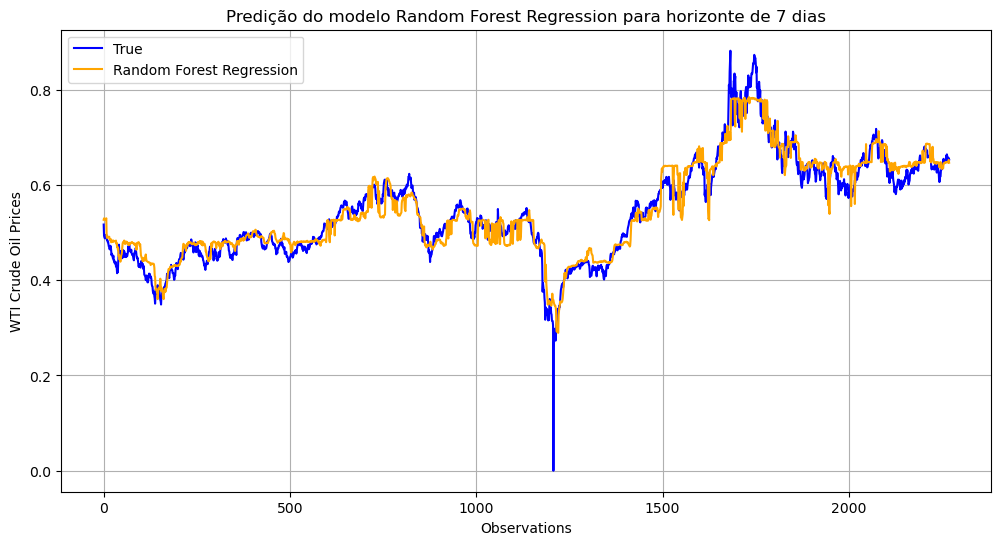

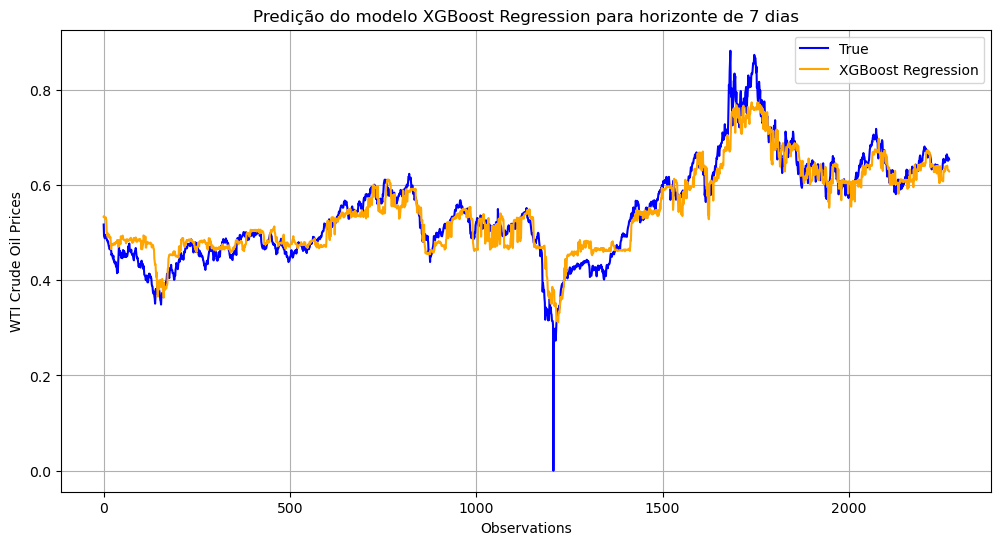

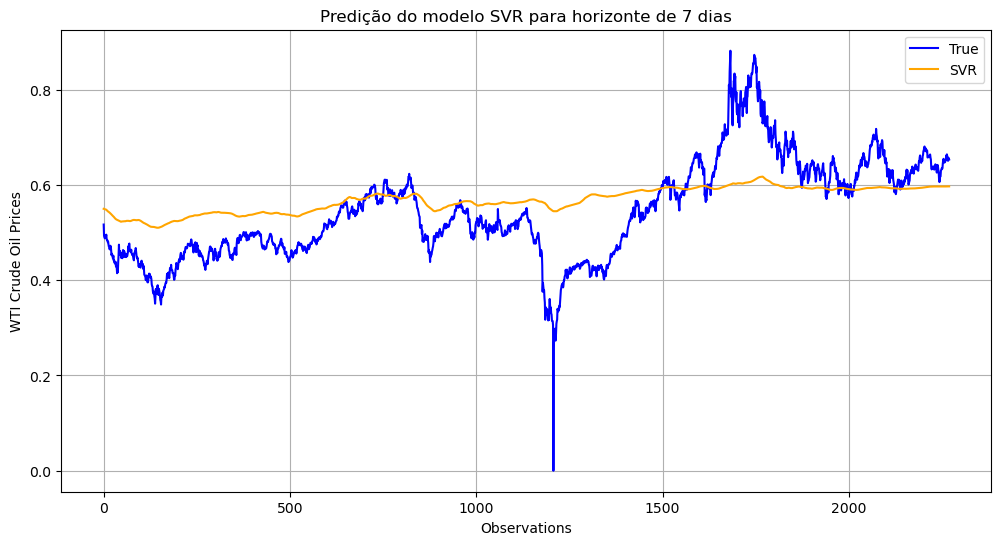

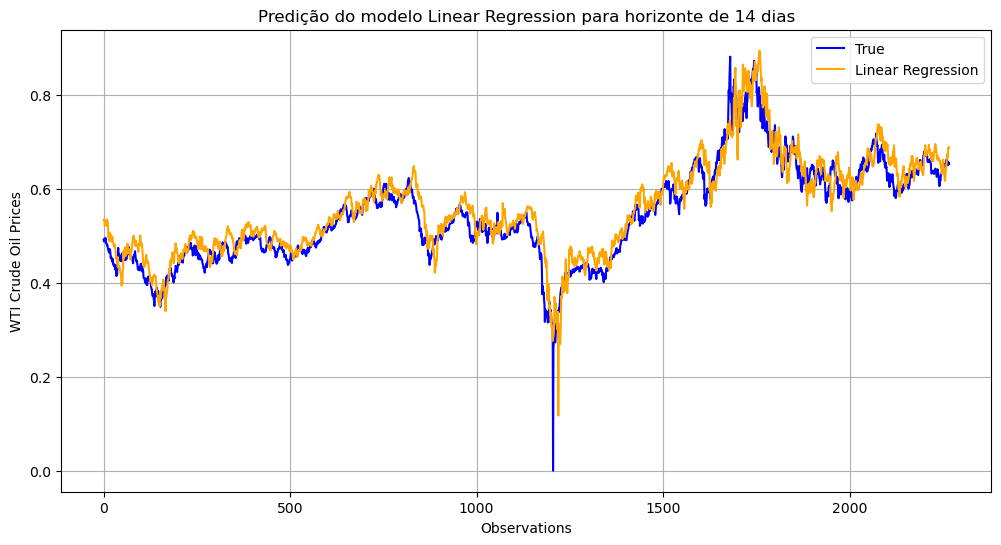

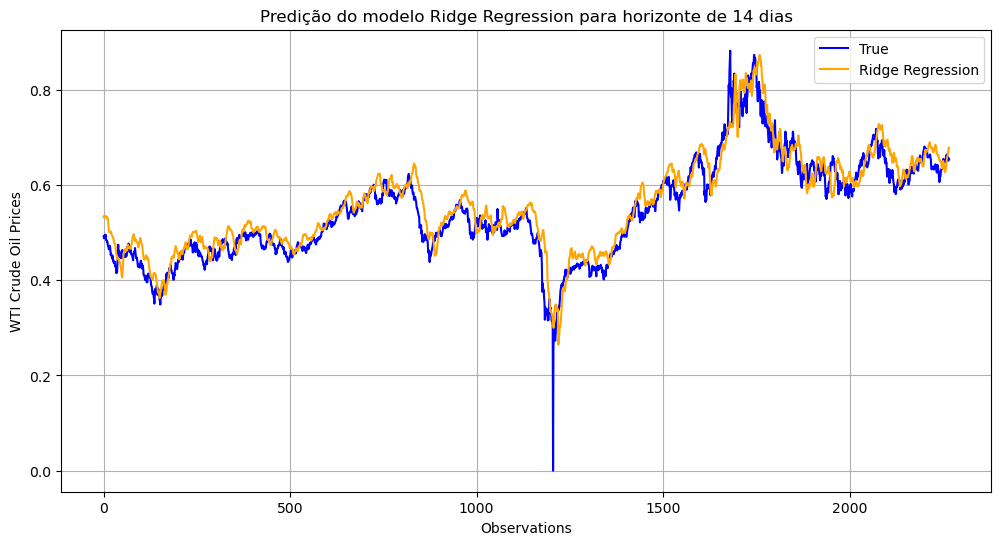

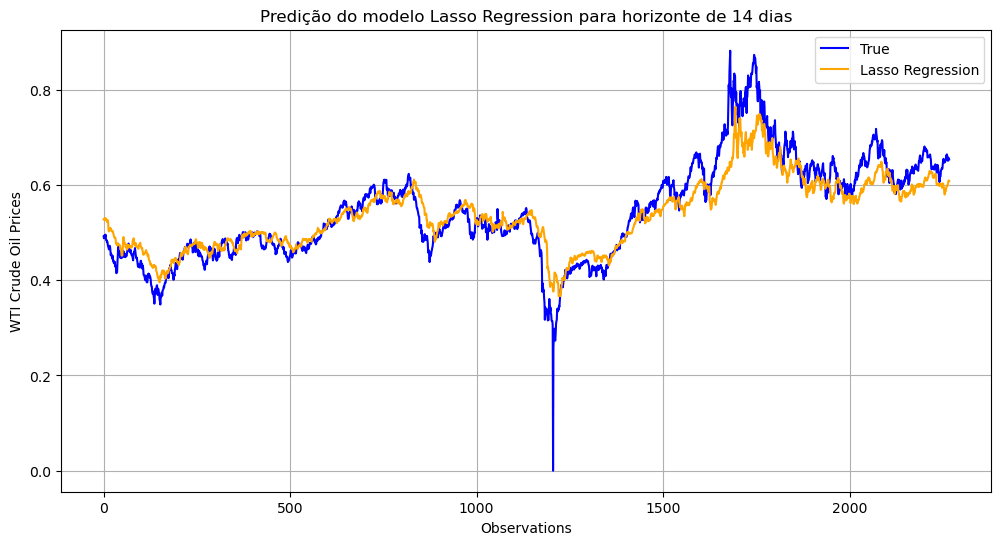

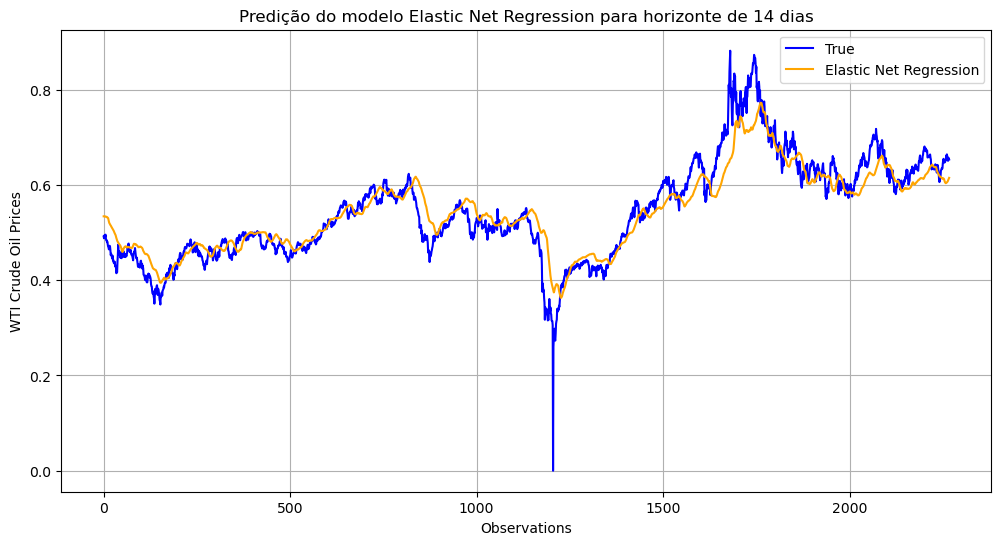

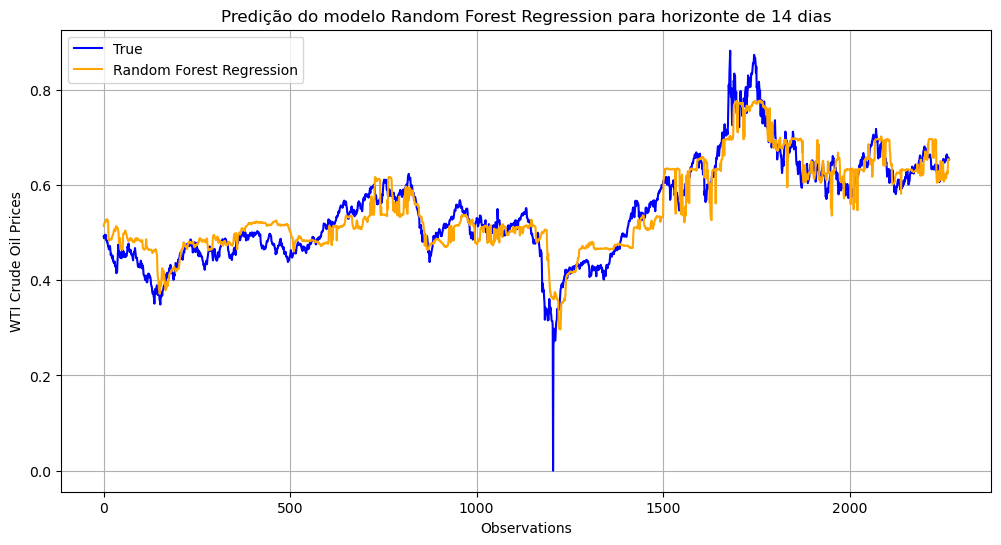

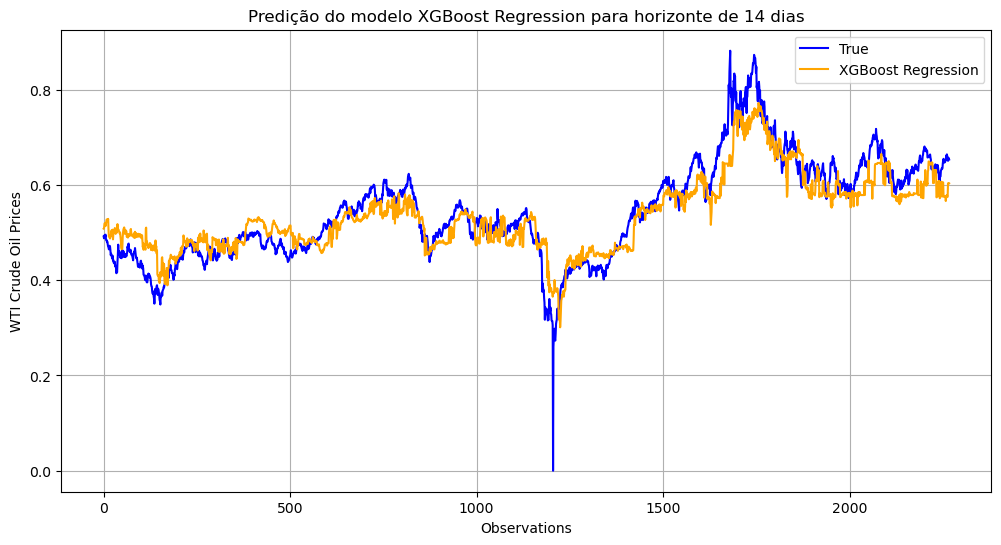

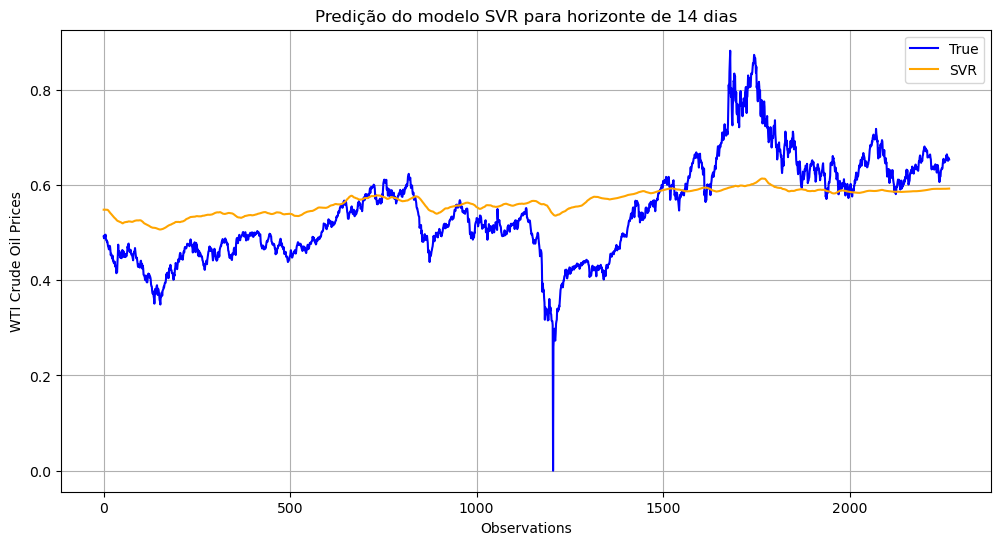

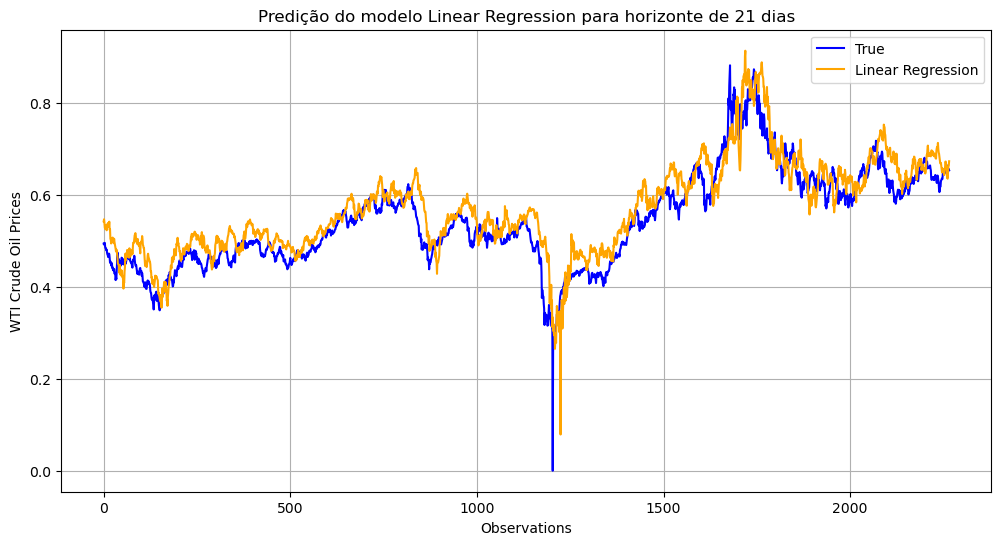

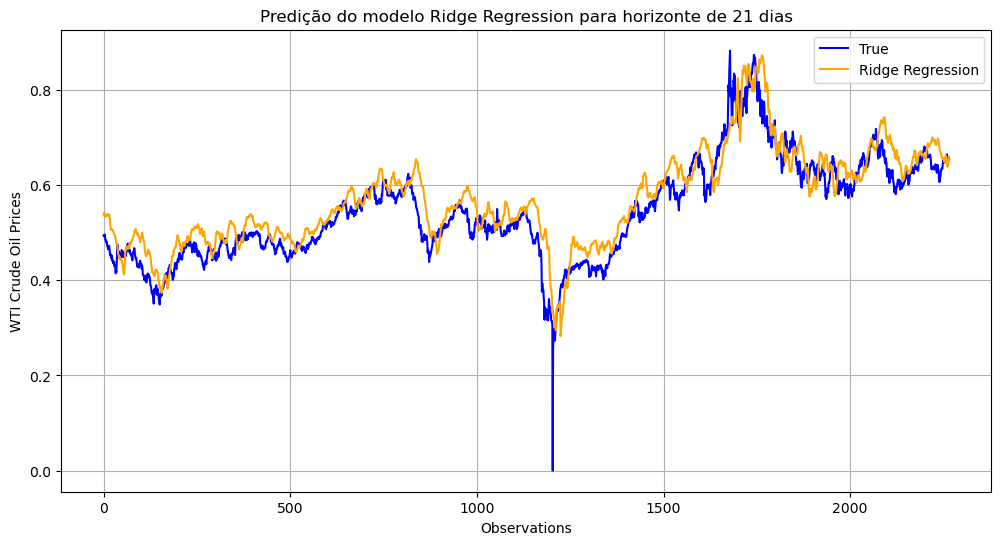

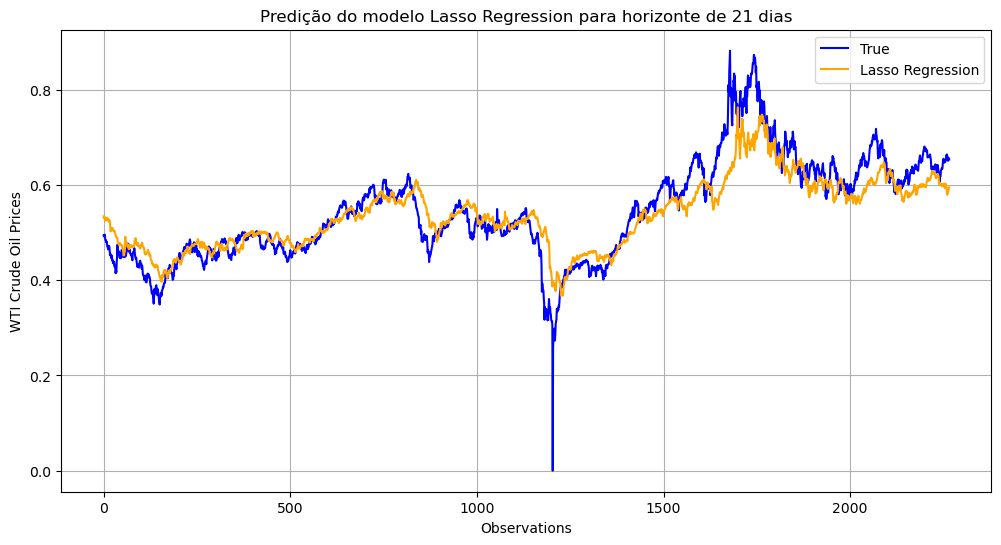

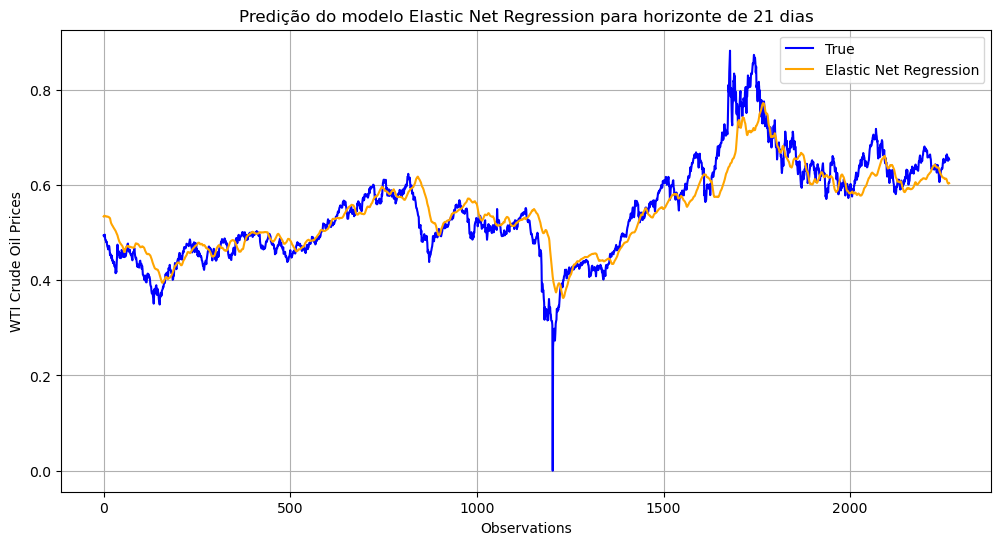

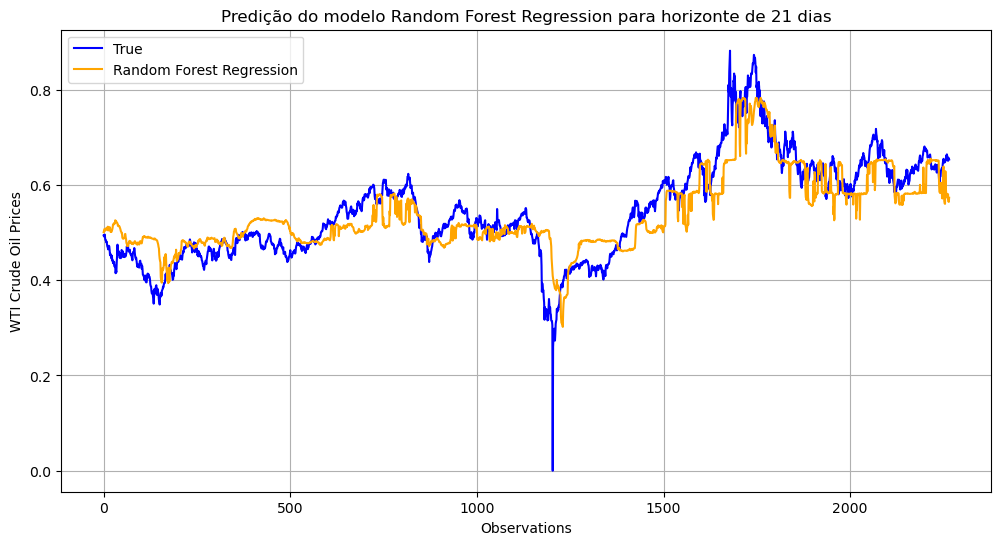

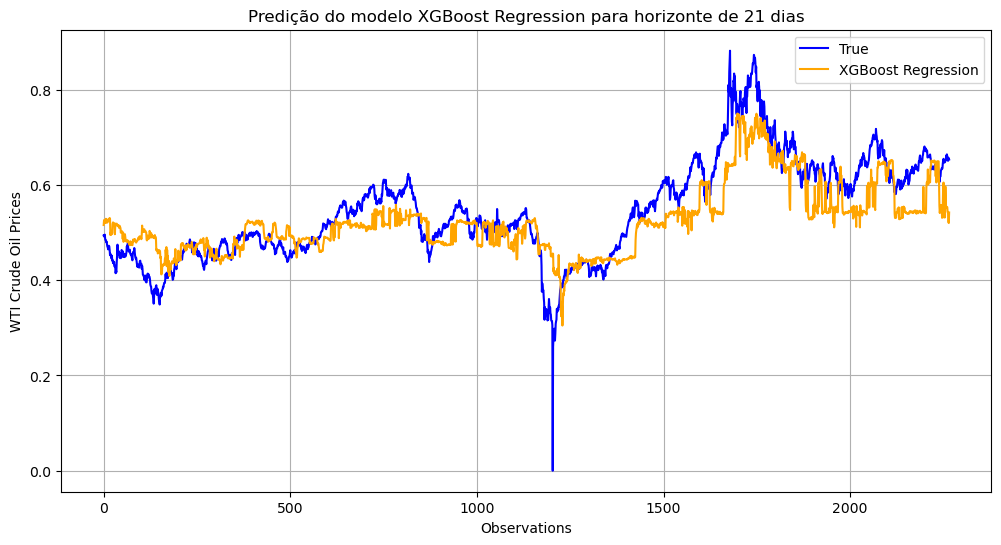

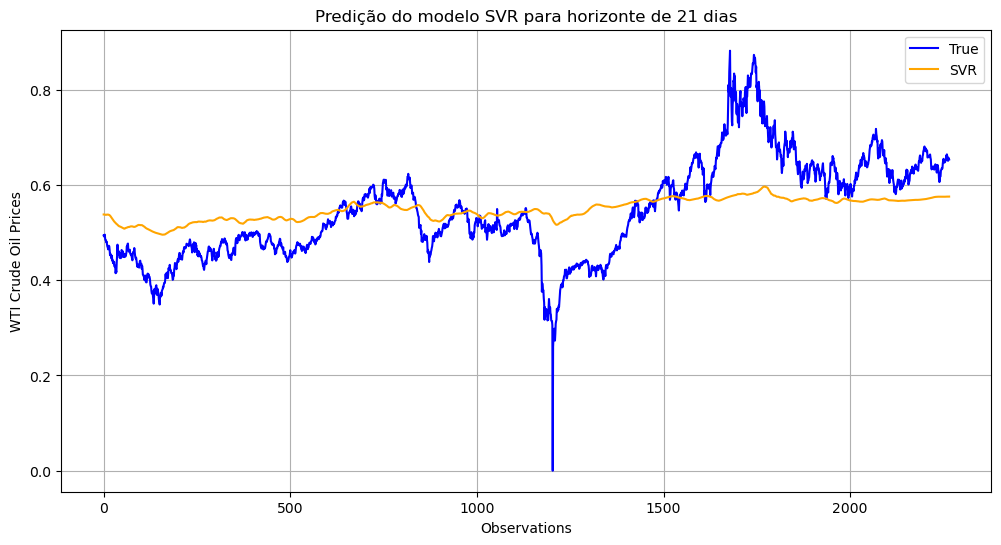

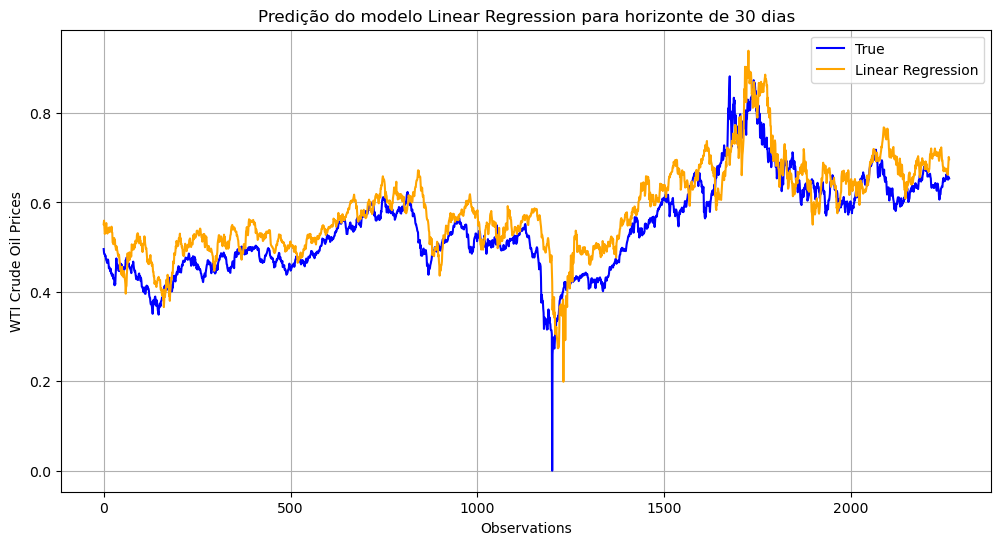

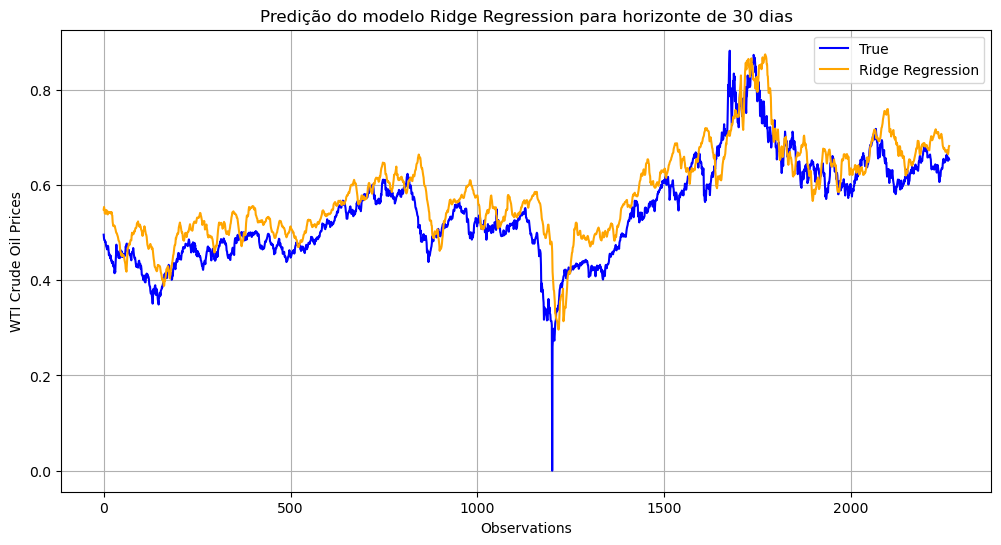

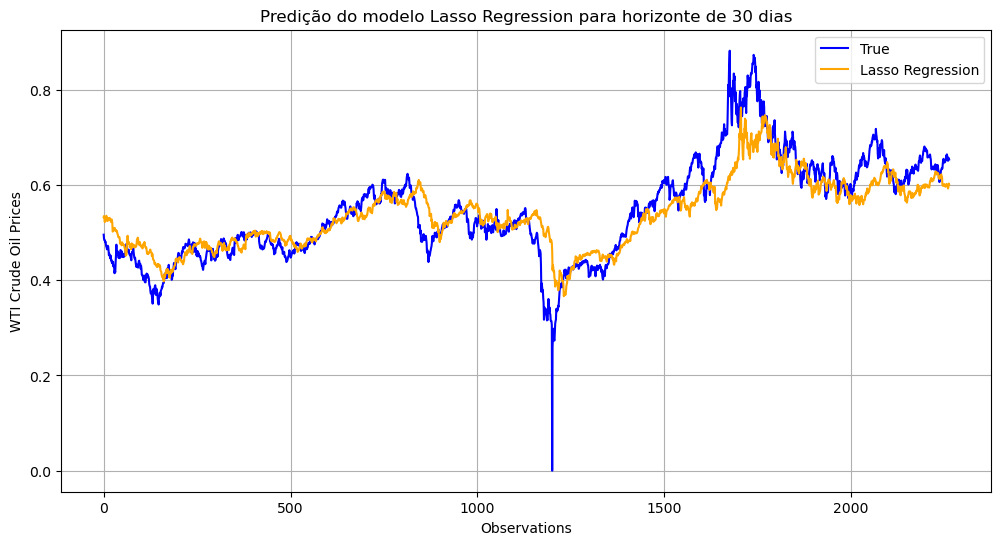

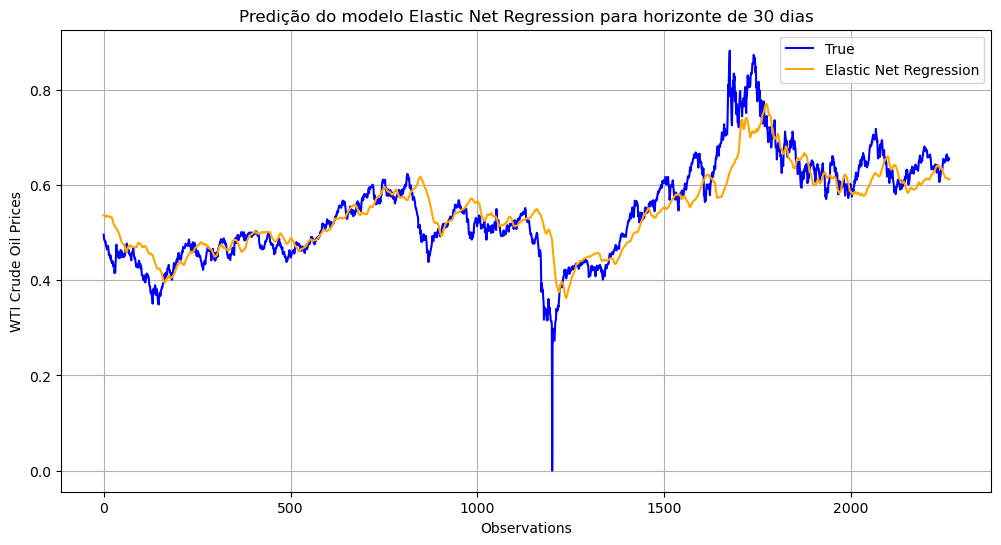

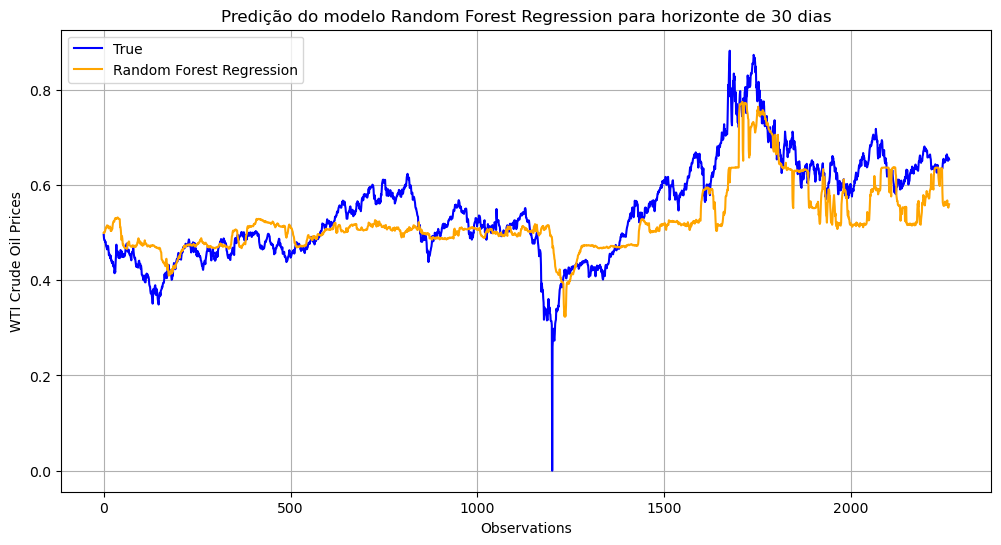

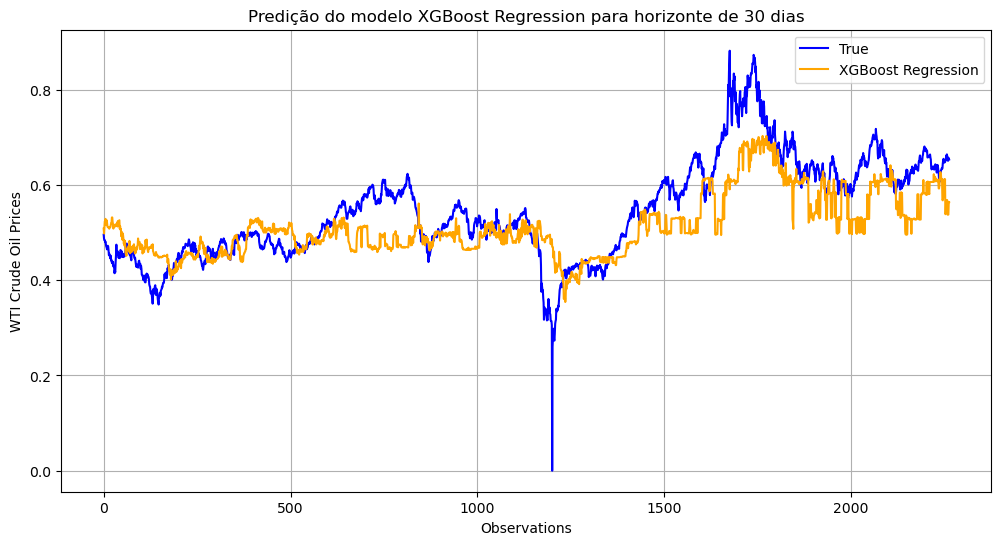

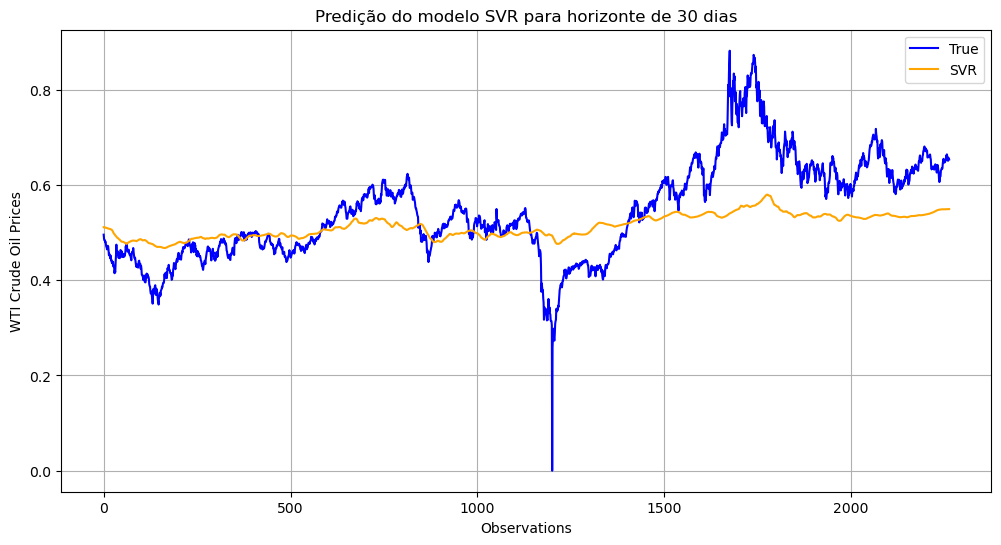

In [116]:
# Plotar previsões vs valores reais para cada modelo e horizonte
for horizon in horizons:
    for name in model_names:
        y_test = split_data_dict[horizon][3]  # y_test é o quarto elemento da tupla retornada por train_test_split
        y_pred = results[name][horizon]["y_pred"]
        plot_predictions(y_test, y_pred, name, horizon)

Os modelos Lasso e Elastic Net Regression já foram corrigidos

Retirar o Brent pode ser uma forma de testar novamente os modelos e ver se a LinearRegression obtém piores resultados. 

Além disso, será importante obter os dados do GAS Natural, assim como os Spot Prices de todas as variáveis, incluindo os do WTI, já que estamos a trablhar com os Future Prices, o que é mais usado para negociar commodities no long-term. Neste caso em específico, a GALP fornece o combustível à FAP provavelmente segundo os Spot Prices do mercado.